# **BERT Multi-Class Classification**



### This notebook is for fine-tuneing ClinicalBERT for multi-class text classification tasks. We'll be using a COVID tweets data with 5 different classes.

In [ ]:
# In order for torch to use the GPU, we need to identify and specify the GPU as the device

# Import torch
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
# Install transformers package from HuggingFace
!pip install transformers
print('Transformers loaded ...')

In [ ]:
# Install pyjanitor for clean dataset
!pip install pyjanitor
import janitor as jn

In [ ]:
# Basic library
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
pd.options.display.float_format = '{:,.3f}'.format
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.metrics import f1_score

# Plotting library
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import seaborn as sns
plt.style.use('ggplot')

print('Packages installed ...')

Packages installed ...


# Download and parse the dataset

In [ ]:
# Download the dataset
df = pd.read_csv('/content/Corona_NLP_train.csv', 
                 encoding='latin-1', 
                 usecols=['OriginalTweet', 'Sentiment'])

# Make the column names pythonic
df = jn.clean_names(df)

# Get a glimpe of data
df.head()

,originaltweet,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# Check target distribution
df.sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: sentiment, dtype: int64

In [ ]:
# Let's map the target classes with integers
encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }
# Create a new labels column
df['labels'] = df.sentiment.replace(encoding)
df.head()

,originaltweet,sentiment,labels
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1
1,advice Talk to your neighbours family to excha...,Positive,2
2,Coronavirus Australia: Woolworths to give elde...,Positive,2
3,My food stock is not the only one which is emp...,Positive,2
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


In [ ]:
# Split the dataset by index
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.labels.values,
                                                  stratify=df.labels.values,
                                                  test_size=0.20, 
                                                  random_state=42)

In [ ]:
# Create a new column mapping train and test dataset
df['split'] = ['not_set']*df.shape[0]
df.loc[X_train, 'split'] = 'train'
df.loc[X_val, 'split'] = 'test'
df.head()

,originaltweet,sentiment,labels,split
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1,train
1,advice Talk to your neighbours family to excha...,Positive,2,train
2,Coronavirus Australia: Woolworths to give elde...,Positive,2,train
3,My food stock is not the only one which is emp...,Positive,2,train
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,train


In [ ]:
# Select the dataset by train and test dataset
train_df = df.query("split=='train'")
test_df = df.query("split=='test'")

# Select the ClinicalBERT model

In [ ]:
# Import comunity tokenizer and BERT model
from transformers import  AutoTokenizer, AutoModel

# Select the model
model_name = 'emilyalsentzer/Bio_ClinicalBERT'

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
print('BERT tokenizer loaded...')


BERT tokenizer loaded...


# Checking sequence length distribution

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs
input_ids = []

# Record the length of each sequence
lengths = []

print('Tokenizing tweets ...')

# For every sentence...
for sen in train_df.originaltweet:
    
    # Report progress
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} tweets.'.format(len(input_ids)))
    
    # Encode the sentences
    encoded_sent = tokenizer.encode(
                        sen,                        # Sentence to encode
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]
                        #max_length = 512,          # Truncate all sentences                       
                        #return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    # Add the encoded sentence to the list
    input_ids.append(encoded_sent)

    # Record the non-truncated length
    lengths.append(len(encoded_sent))

print('DONE.')
print('{:>10,} comments'.format(len(input_ids)))

Tokenizing tweets ...
  Read 0 tweets.
  Read 20,000 tweets.
DONE.
    32,925 comments


In [ ]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 4 tokens
   Max length: 249 tokens
Median length: 58.0 tokens


# Perform tokenization

In [ ]:
# Set up the parameters
max_len = 300
batch_size = 32
epochs = 4

In [ ]:
def my_tokenize(text, labels, max_len):
    '''
    Tokenize a dataset of tweets
    '''
    # Tokenize all of the sentences and map the tokens to thier word IDs
    input_ids = []
    attention_masks = []

    print('Tokenizing {:,} tweets...'.format(len(text)))

    # For every tweet ("sentence")...
    for sent in text:

        # Report progress
        if ((len(input_ids) % 2000) == 0):
            print('  Tokenized {:,} tweets.'.format(len(input_ids)))

        # Encode the sentences
        encoded_dict = tokenizer.encode_plus(
                            sent,                         # Sentence to encode
                            add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                            max_length = max_len,         # Pad & truncate all sentences
                            padding = 'max_length',
                            return_attention_mask = True,   # Construct attn. masks
                            return_tensors = 'pt',        # Return pytorch tensors
                    )
         
        # Add the encoded sentence to the list   
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a tensor
    labels = torch.tensor(labels)

    return (input_ids, labels, attention_masks)

Let's use the above function to perform the tokenization of the training tweets

In [ ]:
# Tokenize the entire training set
(train_input_ids, train_labels, train_attention_masks) = my_tokenize(train_df.originaltweet.values, 
                                                                     train_df.labels.values, 
                                                                     max_len = max_len)

Tokenizing 32,925 tweets...
  Tokenized 0 tweets.
  Tokenized 2,000 tweets.
  Tokenized 4,000 tweets.
  Tokenized 6,000 tweets.
  Tokenized 8,000 tweets.
  Tokenized 10,000 tweets.
  Tokenized 12,000 tweets.
  Tokenized 14,000 tweets.
  Tokenized 16,000 tweets.
  Tokenized 18,000 tweets.
  Tokenized 20,000 tweets.
  Tokenized 22,000 tweets.
  Tokenized 24,000 tweets.
  Tokenized 26,000 tweets.
  Tokenized 28,000 tweets.
  Tokenized 30,000 tweets.
  Tokenized 32,000 tweets.


Let's take a peak at one of the training examples.

In [ ]:
# Print sentence 2, now as a list of IDs.
print('Original: ', train_df.originaltweet[2])
print('Token IDs:', train_input_ids[2])

Original:  Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
Token IDs: tensor([  101,  1884, 15789, 27608, 12686, 16468,  4567,   131, 13103,  4189,
         1116,  1106,  1660,  9808,   117, 10302,  3256,  6001,  2005, 15872,
         1884, 18312,   118,  1627,  8010, 18630,   131,   120,   120,   189,
          119,  1884,   120,  9055,  2599,  1580,  1964,  1643,  1604,  1643,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,   

Now tokenize the test dataset.

In [ ]:
# Tokenize the entire test set
(test_input_ids, test_labels, test_attention_masks) = my_tokenize(test_df.originaltweet.values, 
                                                                  test_df.labels.values, 
                                                                  max_len = max_len)

Tokenizing 8,232 tweets...
  Tokenized 0 tweets.
  Tokenized 2,000 tweets.
  Tokenized 4,000 tweets.
  Tokenized 6,000 tweets.
  Tokenized 8,000 tweets.


# BERT fine-tuning

In [ ]:
# Load pre-trained model
from transformers import AutoModelForSequenceClassification, AdamW, BertConfig

# Load AutoModelForSequenceClassification, with a single linear classification layer on top
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, # Use the Clinical BERT model
    num_labels = 3, # The number of target class
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Tell pytorch to run this model on the GPU
desc = model.cuda()

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

# Splitting off a validation set


This dataset already has a train / test split, but we're going to further divide up our training set to detect over-fitting during the training process. We will use 90% for training and 10% for *validation*. 

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset
dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

29,632 training samples
3,293 validation samples


# DataLoaders

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Select the batch size for training
batch_size = 16

# Create the DataLoaders for our training set
train_dataloader = DataLoader(
            train_dataset,  # The training samples
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size
        )

# Create the DataLoaders for our test training set
validation_dataloader = DataLoader(
            val_dataset, # The validation samples
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially
            batch_size = batch_size # Evaluate with this batch size
        )

# Optimizer


In [ ]:
# Specify the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate, default is 5e-5
                  eps = 1e-8 # args.adam_epsilon, default is 1e-8
                )

# Epochs & Learning Rate Scheduler

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps == number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Performance metrics

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training loop

In [ ]:
# Set the seed value all over the place
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Instantiate the training stats
training_stats = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes
            elapsed = format_time(time.time() - t0)
            
            # Report progress
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear previous gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader and
        # copy each tensor to the GPU using the `to` method
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to compute graph during
        # the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,852.    Elapsed: 0:00:51.
  Batch   200  of  1,852.    Elapsed: 0:01:42.
  Batch   300  of  1,852.    Elapsed: 0:02:33.
  Batch   400  of  1,852.    Elapsed: 0:03:24.
  Batch   500  of  1,852.    Elapsed: 0:04:15.
  Batch   600  of  1,852.    Elapsed: 0:05:07.
  Batch   700  of  1,852.    Elapsed: 0:05:58.
  Batch   800  of  1,852.    Elapsed: 0:06:49.
  Batch   900  of  1,852.    Elapsed: 0:07:40.
  Batch 1,000  of  1,852.    Elapsed: 0:08:31.
  Batch 1,100  of  1,852.    Elapsed: 0:09:22.
  Batch 1,200  of  1,852.    Elapsed: 0:10:13.
  Batch 1,300  of  1,852.    Elapsed: 0:11:04.
  Batch 1,400  of  1,852.    Elapsed: 0:11:55.
  Batch 1,500  of  1,852.    Elapsed: 0:12:46.
  Batch 1,600  of  1,852.    Elapsed: 0:13:37.
  Batch 1,700  of  1,852.    Elapsed: 0:14:28.
  Batch 1,800  of  1,852.    Elapsed: 0:15:19.

  Average training loss: 0.54
  Training epcoh took: 0:15:45

Running Validation...
  Accuracy: 0.87
  Validat

# Check over-fitting

Let's view the summary of the training process

In [ ]:
# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('epoch')

# Display floats with two decimal places
pd.set_option('precision', 2)

# Display the table
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.545,0.365,0.875,0:15:45,0:00:35
2,0.293,0.327,0.900,0:15:45,0:00:35
3,0.215,0.381,0.902,0:15:44,0:00:35
4,0.162,0.388,0.906,0:15:44,0:00:35


Let's take a look at our training loss over all epochs:

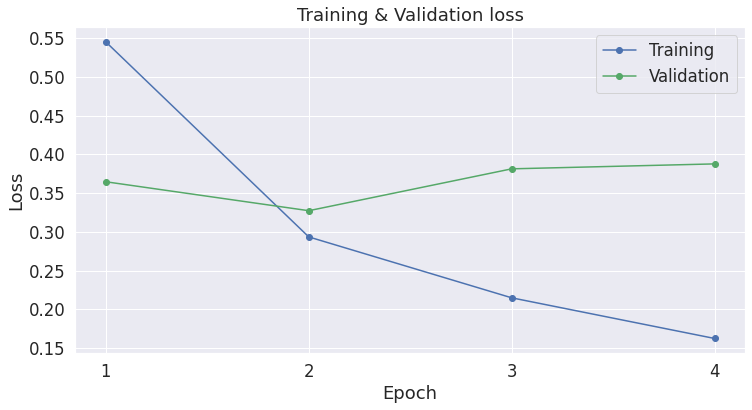

In [ ]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot
plt.title("Training & Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

It seems to be over-fitting slightly in our third epoch.

# Evaluate BERT on test set



Now we can apply our fine-tuned BERT model to generate predictions on the test set.

In [ ]:
# Combine the features into a dataset object
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create a sequential sampler
test_sampler = SequentialSampler(test_data)

# Create the data loader
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# Predict labels for all test set examples
print('Predicting labels for {:,} test comments...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 50 batches
    if step % 50 == 0 and not step == 0:
        # Calculate elapsed time in minutes
        elapsed = format_time(time.time() - t0)
        
        # Report progress
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store the compute graph, saving memory
    # and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 8,232 test comments...
  Batch    50  of    515.    Elapsed: 0:00:08.
  Batch   100  of    515.    Elapsed: 0:00:17.
  Batch   150  of    515.    Elapsed: 0:00:25.
  Batch   200  of    515.    Elapsed: 0:00:34.
  Batch   250  of    515.    Elapsed: 0:00:42.
  Batch   300  of    515.    Elapsed: 0:00:51.
  Batch   350  of    515.    Elapsed: 0:00:59.
  Batch   400  of    515.    Elapsed: 0:01:07.
  Batch   450  of    515.    Elapsed: 0:01:16.
  Batch   500  of    515.    Elapsed: 0:01:24.
    DONE.


To turn our model outputs into actual predictions, we need to:

1. Re-combine the predictions from across all of the batches.
2. Pick a class label for each prediction by choosing the class with the highest output value.

In [ ]:
# Combine the results across the batches
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Take the highest scoring output as the predicted label
predicted_labels = np.argmax(predictions, axis=1)

print('`predictions` has shape', predictions.shape)
print('`predicted_labels` has shape', predicted_labels.shape)

`predictions` has shape (8232, 3)
`predicted_labels` has shape (8232,)


Let's peek at the model's outputs for the first 10 test samples, along with the correct labels for each.

In [ ]:
# Reduce printing precision for legibility
np.set_printoptions(precision=2)

print("Predicted:", str(predicted_labels[0:10]))
print("  Correct:", str(true_labels[0:10]))

Predicted: [2 0 1 1 2 0 0 2 0 1]
  Correct: [2 0 1 1 2 0 0 2 0 1]


In [ ]:
# Use the F1 metric to score our classifier's performance on the test set
score = f1_score(true_labels, predicted_labels, average='macro')

# Print the F1 score!
print('F1 score: {:.3}'.format(score))

F1 score: 0.901
